In [1]:
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("read csv file").getOrCreate()

ip_df = spark.read.csv('IpAddress_to_Country.csv', header=True, inferSchema=True)
transaction_df = spark.read.csv('Fraud_Data.csv', header=True, inferSchema=True)

cond = [transaction_df.ip_address >= ip_df.lower_bound_ip_address,
        transaction_df.ip_address <= ip_df.upper_bound_ip_address]
transaction_df = transaction_df.join(ip_df, cond, 'left')

transaction_df.summary().show()

+-------+------------------+-------------------+-------------------+------------------+-------------+------+-------+------+-----------------+--------------------+-------------------+----------------------+----------------------+-----------+
|summary|           user_id|        signup_time|      purchase_time|    purchase_value|    device_id|source|browser|   sex|              age|          ip_address|              class|lower_bound_ip_address|upper_bound_ip_address|    country|
+-------+------------------+-------------------+-------------------+------------------+-------------+------+-------+------+-----------------+--------------------+-------------------+----------------------+----------------------+-----------+
|  count|            151112|             151112|             151112|            151112|       151112|151112| 151112|151112|           151112|              151112|             151112|                129146|                129146|     129146|
|   mean|200171.04096961193|        

In [2]:
import math
from pyspark.sql.functions import col, expr, when, substring, unix_timestamp
transaction_df = transaction_df.withColumn('purchase_tod', substring(col('purchase_time'), 12, 2))
transaction_df = transaction_df.withColumn('purchase_size', when(col('purchase_value').cast('int') < 40, 0).otherwise(when(col('purchase_value').cast('int') < 60, 1).otherwise(when(col('purchase_value').cast('int') < 90, 2).otherwise(3))))
transaction_df = transaction_df.withColumn('age_bin', when(col('age').cast('int') < 21, 0).otherwise(when(col('age').cast('int') < 65, 1).otherwise(2)))
transaction_df = transaction_df.withColumn('waited_seconds', (unix_timestamp(col('purchase_time')) - unix_timestamp(col('signup_time'))).cast('long'))
transaction_df = transaction_df.withColumn('waited', when(col('waited_seconds').cast('int') < 60, 0).otherwise(when(col('waited_seconds').cast('int') < 3600*12, 1).otherwise(when(col('waited_seconds').cast('int') < 3600*24*30, 2).otherwise(3))))

model_df = transaction_df.select('source', 'browser', 'sex', 'country', 'purchase_tod', 'purchase_size', 'age_bin', 'waited', 'class')
model_df = model_df.where("source is not null and browser is not null and sex is not null and country is not null and purchase_tod is not null and waited is not null and class is not null")

model_df.printSchema()

model_df.show(10)

model_df.summary().show()


root
 |-- source: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- country: string (nullable = true)
 |-- purchase_tod: string (nullable = true)
 |-- purchase_size: integer (nullable = false)
 |-- age_bin: integer (nullable = false)
 |-- waited: integer (nullable = false)
 |-- class: integer (nullable = true)

+------+-------+---+-------------+------------+-------------+-------+------+-----+
|source|browser|sex|      country|purchase_tod|purchase_size|age_bin|waited|class|
+------+-------+---+-------------+------------+-------------+-------+------+-----+
|   SEO| Chrome|  M|        Japan|          02|            0|      1|     3|    0|
|   Ads| Chrome|  F|United States|          01|            0|      1|     1|    0|
|   SEO|  Opera|  M|United States|          18|            0|      1|     0|    1|
|   Ads| Safari|  M|United States|          18|            0|      1|     3|    0|
|   Ads| Chrome|  M|       Canada|          08|     

In [3]:
import math
from pyspark.sql.functions import col, expr, when, substring, unix_timestamp
transaction_df = transaction_df.withColumn('purchase_tod', substring(col('purchase_time'), 12, 2))
transaction_df = transaction_df.withColumn('purchase_size', when(col('purchase_value').cast('int') < 40, 'small').otherwise(when(col('purchase_value').cast('int') < 60, 'medium').otherwise(when(col('purchase_value').cast('int') < 90, 'large').otherwise('max'))))
transaction_df = transaction_df.withColumn('age_bin', when(col('age').cast('int') < 21, 'youth').otherwise(when(col('age').cast('int') < 65, 'adult').otherwise('elder')))
transaction_df = transaction_df.withColumn('waited_seconds', (unix_timestamp(col('purchase_time')) - unix_timestamp(col('signup_time'))).cast('long'))
transaction_df = transaction_df.withColumn('waited', when(col('waited_seconds').cast('int') < 60, 'seconds').otherwise(when(col('waited_seconds').cast('int') < 'hours', 1).otherwise(when(col('waited_seconds').cast('int') < 3600*24*30, 'days').otherwise('months'))))

model_df = transaction_df.select('source', 'browser', 'sex', 'country', 'purchase_tod', 'purchase_size', 'age_bin', 'waited', 'class')
model_df = model_df.where("source is not null and browser is not null and sex is not null and country is not null and purchase_tod is not null and waited is not null and class is not null")

model_df.printSchema()

model_df.show(10)


root
 |-- source: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- country: string (nullable = true)
 |-- purchase_tod: string (nullable = true)
 |-- purchase_size: string (nullable = false)
 |-- age_bin: string (nullable = false)
 |-- waited: string (nullable = false)
 |-- class: integer (nullable = true)

+------+-------+---+-------------+------------+-------------+-------+-------+-----+
|source|browser|sex|      country|purchase_tod|purchase_size|age_bin| waited|class|
+------+-------+---+-------------+------------+-------------+-------+-------+-----+
|   SEO| Chrome|  M|        Japan|          02|        small|  adult| months|    0|
|   Ads| Chrome|  F|United States|          01|        small|  adult|   days|    0|
|   SEO|  Opera|  M|United States|          18|        small|  adult|seconds|    1|
|   Ads| Safari|  M|United States|          18|        small|  adult| months|    0|
|   Ads| Chrome|  M|       Canada|          08| 

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderModel

# just in case.  should all be categorical
categoricalColumns = [item[0] for item in model_df.dtypes if item[1].startswith('string')]
# iterate through them
stage_string = [StringIndexer(inputCol= c, outputCol = c + 'Index') for c in categoricalColumns] + [StringIndexer(inputCol='class', outputCol = 'objective')]
stage_encoder = [OneHotEncoder(inputCol= c+'Index', outputCol= c+'Vector') for c in categoricalColumns] + [OneHotEncoder(inputCol='objective', outputCol = 'objectiveVector')]
transform_pipeline = Pipeline(stages = stage_string + stage_encoder)
pm = transform_pipeline.fit(model_df)
new_model_df = pm.transform(model_df)

new_model_df.show(10)

model_df = new_model_df.select('sourceVector', 'browserVector', 'sexVector', 'countryVector', 'purchase_todVector', 'purchase_sizeVector', 'age_binVector', 'waitedVector', 'objective')

model_df.show(10)


+------+-------+---+-------------+------------+-------------+-------+-------+-----+-----------+------------+--------+------------+-----------------+------------------+------------+-----------+---------+-------------+-------------+-------------+---------------+------------------+-------------------+-------------+-------------+---------------+
|source|browser|sex|      country|purchase_tod|purchase_size|age_bin| waited|class|sourceIndex|browserIndex|sexIndex|countryIndex|purchase_todIndex|purchase_sizeIndex|age_binIndex|waitedIndex|objective| sourceVector|browserVector|    sexVector|  countryVector|purchase_todVector|purchase_sizeVector|age_binVector| waitedVector|objectiveVector|
+------+-------+---+-------------+------------+-------------+-------+-------+-----+-----------+------------+--------+------------+-----------------+------------------+------------+-----------+---------+-------------+-------------+-------------+---------------+------------------+-------------------+-------------

In [11]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ['sourceVector', 'browserVector', 'sexVector', 'countryVector', 'purchase_todVector', 'purchase_sizeVector', 'age_binVector', 'waitedVector'], outputCol = 'features')

output = assembler.transform(model_df)

output.show(10)

train_data,test_data = output.randomSplit([0.7,0.3])


+-------------+-------------+-------------+---------------+------------------+-------------------+-------------+-------------+---------+--------------------+
| sourceVector|browserVector|    sexVector|  countryVector|purchase_todVector|purchase_sizeVector|age_binVector| waitedVector|objective|            features|
+-------------+-------------+-------------+---------------+------------------+-------------------+-------------+-------------+---------+--------------------+
|(2,[0],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(180,[2],[1.0])|    (23,[5],[1.0])|      (3,[0],[1.0])|(2,[0],[1.0])|(2,[0],[1.0])|      0.0|(217,[0,2,6,9,192...|
|(2,[1],[1.0])|(4,[0],[1.0])|    (1,[],[])|(180,[0],[1.0])|   (23,[18],[1.0])|      (3,[0],[1.0])|(2,[0],[1.0])|(2,[1],[1.0])|      0.0|(217,[1,2,7,205,2...|
|(2,[0],[1.0])|    (4,[],[])|(1,[0],[1.0])|(180,[0],[1.0])|   (23,[15],[1.0])|      (3,[0],[1.0])|(2,[0],[1.0])|    (2,[],[])|      1.0|(217,[0,6,7,202,2...|
|(2,[1],[1.0])|(4,[2],[1.0])|(1,[0],[1.0])|(180,[0],

In [12]:
from pyspark.ml.classification import (LogisticRegression, GBTClassifier, DecisionTreeClassifier)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

lrc = LogisticRegression(featuresCol = 'features', labelCol = 'objective', maxIter=10)
dtc = DecisionTreeClassifier(featuresCol='features', labelCol='objective')
gbtc = GBTClassifier(featuresCol='features', labelCol='objective', maxIter=30)

lrc_model = lrc.fit(train_data)
dtc_model = dtc.fit(train_data)
gbtc_model = gbtc.fit(train_data)


Multinomial coefficients: DenseMatrix([[ 1.79986794e-02,  5.32442510e-02,  5.33194105e-01,
               5.43558962e-01,  5.79740425e-01,  5.29567196e-01,
               4.64278846e-02,  5.69865153e-01,  6.09657227e-01,
               5.59470054e-01,  6.30619529e-01,  5.06956087e-01,
               5.18313339e-01,  5.52446719e-01,  4.96472520e-01,
               5.32044306e-01,  7.13563843e-01,  5.59691821e-01,
               6.05572533e-01,  8.35536989e-01,  1.93042806e-01,
               7.06003204e-01,  3.45960171e-01,  5.88348346e-01,
               4.02365421e-01,  7.46264938e-01,  6.19898691e-01,
               9.82982377e-01,  7.52549741e-01,  2.04742988e-01,
               7.90895862e-01,  4.11895397e-01,  2.72989020e-01,
               6.33006291e-01, -4.98776246e-02,  4.45823753e-01,
               9.14066350e-01,  5.60162816e-01,  2.43068835e-01,
               4.34653705e-01,  6.31873623e-01,  1.14415241e+00,
               6.47304390e-01,  5.77825540e-01,  4.96675845e-01,

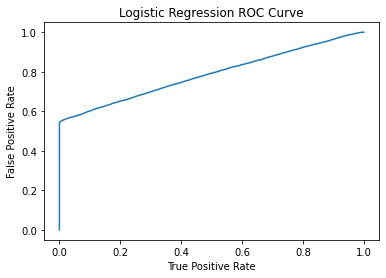

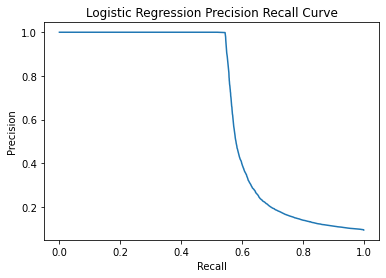

In [13]:
print("Multinomial coefficients:", lrc_model.coefficientMatrix)
lrc_summary = lrc_model.summary
print('Logistic model training set areaUnderROC: ' + str(lrc_summary.areaUnderROC))

roc = lrc_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

pr = lrc_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Logistic Regression Precision Recall Curve')
plt.show()


(217,[0,2,41,108,159,185,202,215,216],[0.00012356641809506264,0.00016475522412675022,0.00010903689855483372,0.00010229779635598459,0.0002253418263669991,0.00022490295591592977,0.00034201614046435304,0.13335896004976466,0.8653491226903555])
+------------+-------------+---------+---------------+------------------+-------------------+-------------+-------------+---------+--------------------+----------------+--------------------+----------+
|sourceVector|browserVector|sexVector|  countryVector|purchase_todVector|purchase_sizeVector|age_binVector| waitedVector|objective|            features|   rawPrediction|         probability|prediction|
+------------+-------------+---------+---------------+------------------+-------------------+-------------+-------------+---------+--------------------+----------------+--------------------+----------+
|   (2,[],[])|    (4,[],[])|(1,[],[])|(180,[0],[1.0])|    (23,[6],[1.0])|      (3,[0],[1.0])|(2,[0],[1.0])|(2,[0],[1.0])|      0.0|(217,[7,193,210,2...|[6

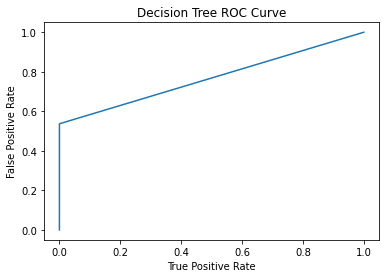

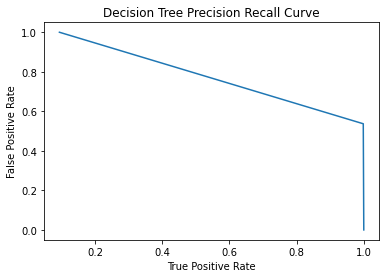

 idx                                name    score
 216                   waitedVector_days 0.865349
 215                 waitedVector_months 0.133359
 202               purchase_todVector_18 0.000342
 159 countryVector_Virgin Islands (U.S.) 0.000225
 185          countryVector_Turkmenistan 0.000225
   2                browserVector_Chrome 0.000165
   0                    sourceVector_SEO 0.000124
  41               countryVector_Belgium 0.000109
 108               countryVector_Iceland 0.000102
 140              countryVector_Mongolia 0.000000


In [14]:
from sklearn.metrics import roc_curve, precision_recall_curve
import pandas as pd;
print(dtc_model.featureImportances)
dt_predictions = dtc_model.transform(test_data)
dt_predictions.show(10)

label_obj = [float(row['objective']) for row in dt_predictions.select('objective','prediction').collect()]
prediction = [float(row['prediction']) for row in dt_predictions.select('objective','prediction').collect()]
roc = roc_curve(label_obj,prediction)
plt.plot(roc[0],roc[1])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()

pr = precision_recall_curve(label_obj,prediction)
plt.plot(pr[0],pr[1])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Decision Tree Precision Recall Curve')
plt.show()

# a display shortcut I found online
def ExtractFeatureImportance(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return (varlist.sort_values('score', ascending=False))

dataset_fi = ExtractFeatureImportance(dtc_model.featureImportances, dt_predictions, "features")
print(dataset_fi.head(10).to_string(index=False))


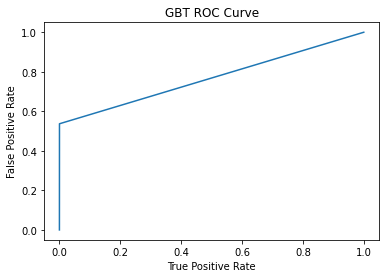

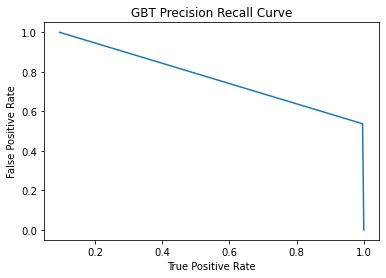

 idx                  name    score
 216     waitedVector_days 0.818718
 215   waitedVector_months 0.124234
   0      sourceVector_SEO 0.004507
   3      browserVector_IE 0.004043
   1      sourceVector_Ads 0.003590
   2  browserVector_Chrome 0.003163
   6           sexVector_M 0.002840
 200 purchase_todVector_13 0.002439
  34 countryVector_Romania 0.001698
   4  browserVector_Safari 0.001527



In [15]:
gbt_predictions = gbtc_model.transform(test_data)
label_obj = [float(row['objective']) for row in gbt_predictions.select('objective','prediction').collect()]
prediction = [float(row['prediction']) for row in gbt_predictions.select('objective','prediction').collect()]
roc = roc_curve(label_obj,prediction)
plt.plot(roc[0],roc[1])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('GBT ROC Curve')
plt.show()

pr = precision_recall_curve(label_obj,prediction)
plt.plot(pr[0],pr[1])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('GBT Precision Recall Curve')
plt.show()

dataset_fi = ExtractFeatureImportance(gbtc_model.featureImportances, gbt_predictions, "features")
print(dataset_fi.head(10).to_string(index=False))

print()
